In [33]:
import gzip
import os
import struct
import urllib.request
import array

import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import diffrax as dfx
import equinox as eqx
from equinox import nn
import matplotlib.pyplot as plt
import numpy as np

from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5

# change backend of jax to cpu. I needed it as the library diffrax is 
# not compatible with metal distribution of jax (jax-metal)
jax.config.update('jax_platform_name', 'cpu')

In [36]:
# produce forward solver for pendulum problem

def calculate_force(t):
    return 10. * jnp.sin(t)

def vector_field(t, state, args):
    x, theta, x_dot, theta_dot = state
    M, m, g, l = args
    F = calculate_force(t)

    x_dot_dot = (F - m * g * jnp.cos(theta) * jnp.sin(theta) + m * l * (theta_dot ** 2) * jnp.sin(theta)) / (M + m  - m * (jnp.cos(theta) ** 2))
    theta_dot_dot = (g * jnp.sin(theta) - x_dot_dot * jnp.cos(theta)) / (l)

    return jnp.array([x_dot, theta_dot, x_dot_dot, theta_dot_dot])

@jax.jit
def solve(state0, args):
    term = dfx.ODETerm(vector_field)
    solver = dfx.Tsit5()
    t0 = 0
    tN = 5
    dt0 = 0.1
    saveat = dfx.SaveAt(ts=jnp.linspace(t0, tN, 1000))
    sol = dfx.diffeqsolve(term, solver, t0, tN, dt0, state0, args=args, saveat=saveat)
    return sol

state0 = jnp.array([0., jnp.pi/4, 0., 0.])
M, m, g, l = 1., 0.1, 9.81, 1.
args = (M, m, g, l)

sol = solve(state0, args)

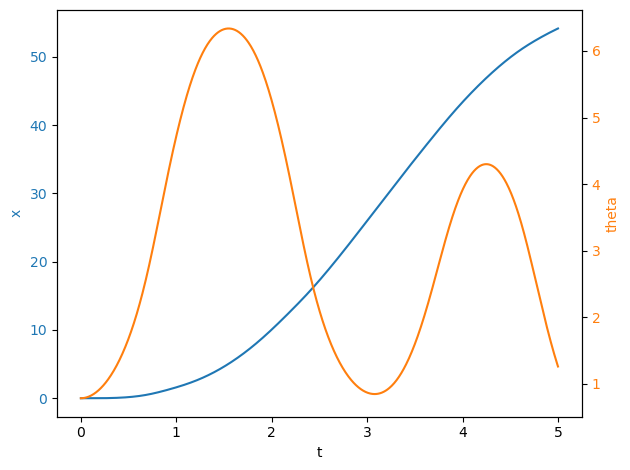

In [37]:

#plotting

fig, ax1 = plt.subplots()
ax1.set_xlabel('t')
ax1.set_ylabel('x', color='tab:blue')
ax1.plot(sol.ts, sol.ys[:, 0], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('theta', color='tab:orange')
ax2.plot(sol.ts, sol.ys[:, 1], color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.show()


In [129]:
class FCN(eqx.Module):
    "Fully-connected neural network, with 1 hidden layer, from tutorial"

    input_layer: nn.Linear
    hidden_layer: nn.Linear
    output_layer: nn.Linear

    def __init__(self, in_size, hidden_size, out_size, key):
        "Initialise network parameters"

        key1, key2, key3 = jr.split(key, 3)
        self.input_layer = nn.Linear(in_size, hidden_size, key=key1)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size, key=key2)
        self.output_layer = nn.Linear(hidden_size, out_size, key=key3)

    def __call__(self, x):
        "Defines forward model"

        x = jax.nn.tanh(self.input_layer(x))
        x = jax.nn.tanh(self.hidden_layer(x))
        x = self.output_layer(x)
        return x


# create a network with 32 hidden units
key = jr.key(0)
model = FCN(1, 32, 1, key)
print(model)


# Define the system of ODEs with neural network control
def vector_field_2(t, y, model):
    x, x_dot, theta, theta_dot = y
    F = model(jnp.array([t])).squeeze()  # Use the neural network to compute F
    x_ddot = (
        F
        - 0.1 * 9.81 * jnp.cos(theta) * jnp.sin(theta)
        + 0.1 * 1.0 * theta_dot**2 * jnp.sin(theta)
    ) / (1.0 + 0.1 - 0.1 * jnp.cos(theta) ** 2)
    theta_ddot = (9.81 * jnp.sin(theta) - x_ddot * jnp.cos(theta)) / 1.0
    return jnp.array([x_dot, x_ddot, theta_dot, theta_ddot])


# Define the cost function
@jax.jit
def loss_fn(model, y0):
    term = ODETerm(vector_field_2)
    solver = Tsit5()
    saveat = SaveAt(ts=jnp.linspace(0.0, 5.0, 500))
    solution = diffeqsolve(
        term,
        solver,
        t0=0.0,
        t1=5.0,
        dt0=1e-3,
        y0=y0,
        args=model,
        saveat=saveat,
        max_steps=100000,
    )
    x = solution.ys[:, 0]
    x_dot = solution.ys[:, 1]
    theta = solution.ys[:, 2]
    theta_dot = solution.ys[:, 3]
    # normalize theta
    theta = jnp.mod(theta + jnp.pi, 2 * jnp.pi) - jnp.pi
    # return the mean squared error of the last fourth of theta
    F = jax.vmap(model)(jnp.linspace(0.0, 5.0, 500)[:, None])
    return jnp.mean(
        (theta[int(0.75 * theta.shape[0]) :]) ** 2
    ) + 0.3 * jnp.mean(F[int(0.75 * theta.shape[0]) :] ** 2)



# Create the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))


@jax.jit
def update(model, opt_state, y0):
    loss, grads = jax.value_and_grad(loss_fn)(model, y0)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


# Training loop
losses = []
for epoch in range(3000):
    model, opt_state, loss = update(model, opt_state, y0)
    losses.append(loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

FCN(
  input_layer=Linear(
    weight=f32[32,1],
    bias=f32[32],
    in_features=1,
    out_features=32,
    use_bias=True
  ),
  hidden_layer=Linear(
    weight=f32[32,32],
    bias=f32[32],
    in_features=32,
    out_features=32,
    use_bias=True
  ),
  output_layer=Linear(
    weight=f32[1,32],
    bias=f32[1],
    in_features=32,
    out_features=1,
    use_bias=True
  )
)
Epoch 0, Loss: 2.2504403591156006
Epoch 100, Loss: 2.0981321334838867
Epoch 200, Loss: 1.7285182476043701
Epoch 300, Loss: 0.045467570424079895
Epoch 400, Loss: 0.019587025046348572
Epoch 500, Loss: 0.020114295184612274
Epoch 600, Loss: 0.011307540349662304
Epoch 700, Loss: 0.009848886169493198
Epoch 800, Loss: 0.00873955711722374
Epoch 900, Loss: 0.009253113530576229
Epoch 1000, Loss: 0.007237430661916733
Epoch 1100, Loss: 0.006933203432708979
Epoch 1200, Loss: 0.006425201892852783
Epoch 1300, Loss: 0.009210755117237568
Epoch 1400, Loss: 0.006009714212268591
Epoch 1500, Loss: 0.005499882623553276
Epoch 1600,

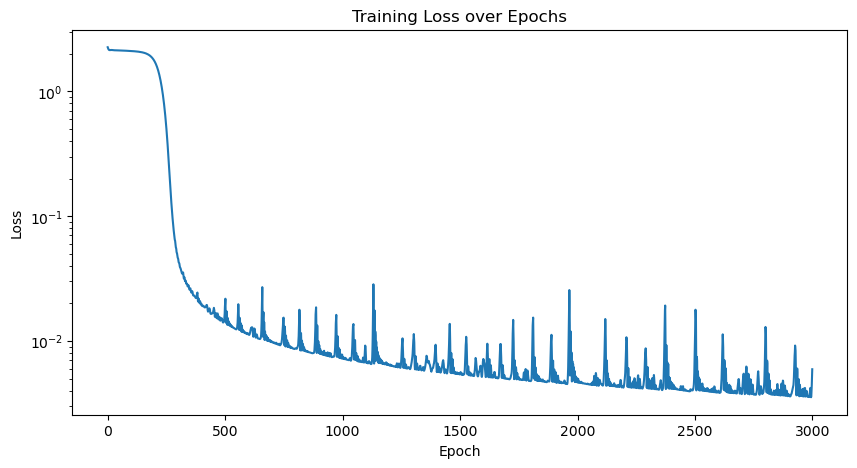

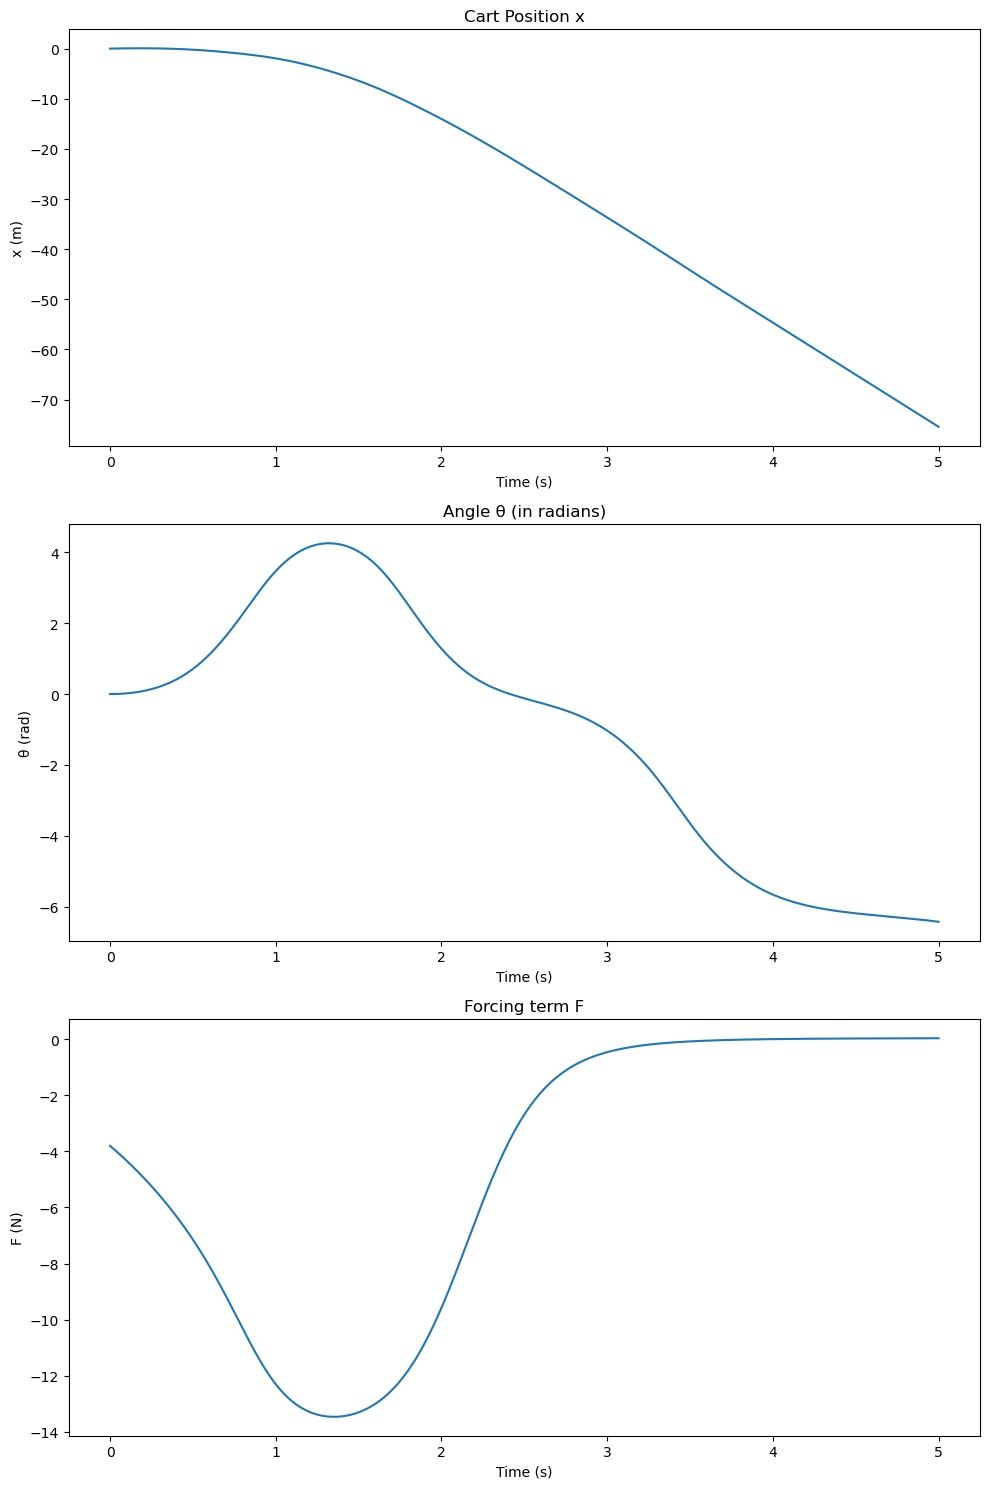

In [130]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

# Simulate with the trained policy
term = ODETerm(vector_field_2)
solver = Tsit5()
saveat = SaveAt(ts=jnp.linspace(0.0, 5.0, 500))
solution = diffeqsolve(
    term,
    solver,
    t0=0.0,
    t1=5.0,
    dt0=1e-3,
    y0=state0,
    args=model,
    saveat=saveat,
    max_steps=100000,
)

# Extract solutions
x_traj = solution.ys[:, 0]
x_dot_traj = solution.ys[:, 1]
theta_traj = solution.ys[:, 2]
theta_dot_traj = solution.ys[:, 3]

# Plot the results
plt.figure(figsize=(10, 15))

plt.subplot(3, 1, 1)
plt.plot(ts, x_traj)
plt.title("Cart Position x")
plt.xlabel("Time (s)")
plt.ylabel("x (m)")

plt.subplot(3, 1, 2)
plt.plot(ts, theta_traj)
plt.title("Angle θ (in radians)")
plt.xlabel("Time (s)")
plt.ylabel("θ (rad)")

plt.subplot(3, 1, 3)
F_traj = jax.vmap(model)(jnp.linspace(0.0, 5.0, 500)[:, None])
plt.plot(ts, F_traj)
plt.title("Forcing term F")
plt.xlabel("Time (s)")
plt.ylabel("F (N)")

plt.tight_layout()
plt.show()

In [132]:
print("the final position is", theta_traj[-1], "radians")
print("the final angle is", theta_traj[-1] + (2 * jnp.pi), "radians")

the final position is -6.431694 radians
the final angle is -0.14850855 radians
